In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import wfdb
import glob
import os
import pywt
import tensorflow as tf
from tqdm import tqdm
import tensorflow as tf
from scipy import signal as scipy_signal
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import  Dense, Dropout, Conv2D, Input, MaxPooling2D,Flatten


In [8]:
!pip install wfdb

Defaulting to user installation because normal site-packages is not writeable


In [9]:
database_names = ['mitdb', 'chfdb']
n_label = len(database_names)
record_names = []
labels = []

for i, name in enumerate(database_names):
    current_record_names = wfdb.get_record_list(name)
    record_names += current_record_names
    labels += [i for record_name in current_record_names]
assert len(record_names) == len(labels)

# Récupération des fréquences d'échantillonnage
frequencies = []
for record_name, label in zip(record_names, labels):
    header = wfdb.rdheader(record_name, database_names[label])
    frequencies.append(header.fs)

In [10]:
import numpy as np
import tensorflow as tf
import wfdb
import scipy.signal as scipy_signal
import pywt

# Fonction pour charger un signal à partir de WFDB
def load_signal(file, start, end, channel, pn_dir):
    record = wfdb.rdrecord(file, sampfrom=start, sampto=end, channels=[channel], pn_dir=pn_dir)
    data = record.p_signal.reshape(-1)
    return data

# Fonction pour synchroniser un signal à une fréquence d'échantillonnage commune
def synchronize_signal(signal, sampling_rate, common_sampling_rate):
    num_samples = int((common_sampling_rate * len(signal)) / sampling_rate)
    signal_resampled = scipy_signal.resample(signal, num_samples)
    return signal_resampled

# Fonction pour générer les coefficients d'ondelettes
def generate_wavelet_coefficients(signal, scales, waveletname):
    coefficients, _ = pywt.cwt(signal, scales, waveletname, 1)
    return coefficients

# Fonction pour générer les données à partir des signaux WFDB
def generate_data_from_wfdb(record_name, label, frequency, nb_samples_per_signal, common_sampling_rate):
    scales = range(1, scale_size + 1)
    waveletname = 'morl'
    y_train = np.zeros(nb_samples_per_signal)
    X_train = []

    pn_dir = database_names[label]
    signal = load_signal(record_name, start=0, end=nb_samples_per_signal * frequency, channel=0, pn_dir=pn_dir)
    signal = synchronize_signal(signal, frequency, common_sampling_rate)
    signal_samples = np.split(signal, nb_samples_per_signal)
    y_train = np.full(nb_samples_per_signal, label)

    for sample in signal_samples:
        coefficients = generate_wavelet_coefficients(sample, scales, waveletname)
        X_train.append(coefficients)

    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_normalized = (X_train - np.mean(X_train)) / np.std(X_train)

    return X_normalized, y_train

# Fonction pour générer les données complètes
def generate_data(sample_size, scale_size, nb_samples_per_signal, labels, record_names, database_names,
                  frequencies, common_sampling_rate):
    X_train = []
    y_train = []

    for i in range(len(record_names)):
        record_name, label, frequency = record_names[i], labels[i], frequencies[i]
        X_batch, y_batch = generate_data_from_wfdb(record_name, label, frequency, nb_samples_per_signal, common_sampling_rate)
        X_train.extend(X_batch)
        y_train.extend(y_batch)

    num_classes = len(np.unique(y_train))
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)

    return np.array(X_train), y_train

# Paramètres
sample_size = 64
scale_size = 64
nb_samples_per_signal = 64
common_sampling_rate = 64

# Génération des données
data_params = {
    'sample_size': sample_size,
    'scale_size': scale_size,
    'nb_samples_per_signal': nb_samples_per_signal,
    'labels': labels,
    'record_names': record_names,
    'database_names': database_names,
    'frequencies': frequencies,
    'common_sampling_rate': common_sampling_rate
}
X_normalized, y = generate_data(**data_params)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.4, random_state=42)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Fonction pour construire le modèle avec des techniques de régularisation
def build_regularized_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D(),
        SpatialDropout2D(0.5),  # Couche de dropout spatial
        Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(),
        SpatialDropout2D(0.5),  # Couche de dropout spatial
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.7),  # Dropout classique
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Réduction du taux d'apprentissage
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Construction du modèle avec régularisation
model = build_regularized_model(X_train.shape[1:], y_train.shape[1])

# Utilisation de callbacks pour éviter l'overfitting
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/10
38/38 [==============================] - 3s 68ms/step - loss: 3.4041 - accuracy: 0.7243 - val_loss: 3.1318 - val_accuracy: 0.7669
Epoch 2/10
38/38 [==============================] - 2s 65ms/step - loss: 2.9719 - accuracy: 0.7586 - val_loss: 2.7834 - val_accuracy: 0.7669
Epoch 3/10
38/38 [==============================] - 2s 64ms/step - loss: 2.6309 - accuracy: 0.7561 - val_loss: 2.4689 - val_accuracy: 0.7669
Epoch 4/10
38/38 [==============================] - 2s 62ms/step - loss: 2.3607 - accuracy: 0.7573 - val_loss: 2.2397 - val_accuracy: 0.7669
Epoch 5/10
38/38 [==============================] - 2s 63ms/step - loss: 2.1430 - accuracy: 0.7586 - val_loss: 2.0608 - val_accuracy: 0.7669
Epoch 6/10
38/38 [==============================] - 2s 63ms/step - loss: 1.9578 - accuracy: 0.7582 - val_loss: 1.8923 - val_accuracy: 0.7669
Epoch 7/10
38/38 [==============================] - 3s 70ms/step - loss: 1.8135 - accuracy: 0.7582 - val_loss: 1.7440 - val_accuracy: 0.7669
Epoch 8/10
38

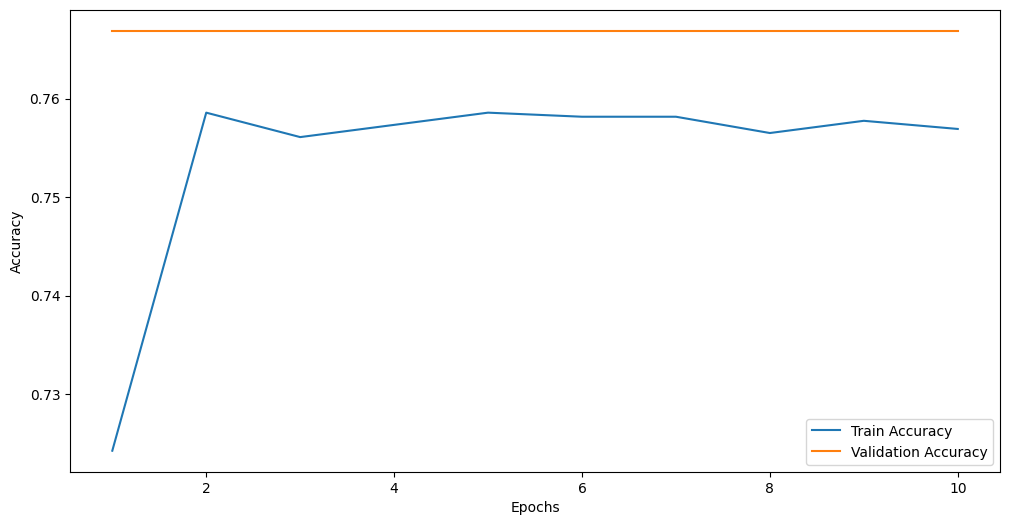

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Tracer l'accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

On constate une indication d'un léger overfitting mais cela peut être lié à la taille du dataset d'entrainement qui semble trop petite. Il y a une possibilité d'augmenter cette taille avec du flou gaussien avec du bruit mais cette méthode n'a pas l'air très rentable 